## Data Analysis Pipeline 
**0. Load data**
   
   
**1. Explore data** 
  
  
**2. Visualize and clean data**    
- 2.1 Visualize all species  
- 2.2 Clean data  
- 2.3 Visualize per species  
- 2.4 Key Insights for Forward Progress
    
    
**3. Build Classifiers**  
- 3.0. Create functions  
- 3.1. Decision Tree  
- 3.2. Random Forest  
- 3.3. Logistic Regression  
- 3.4  Analysis of features importance
    
    
**4. Assessment of the data analysis pipeline effectiveness**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# do not print warnings
import warnings
warnings.filterwarnings("ignore")

# 0. Load Data

In [3]:
data_file_path = "puffins.csv"
df = pd.read_csv(data_file_path)
df

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm,species
0,1.384,0.181,39.243,18.304,Arctica
1,1.717,0.189,44.084,19.240,Arctica
2,1.717,0.184,40.376,19.344,Arctica
3,1.414,0.187,37.904,19.240,Arctica
4,1.273,0.177,37.595,18.720,Arctica
...,...,...,...,...,...
339,1.879,0.207,44.805,15.808,Corniculata
340,1.697,0.202,46.659,14.352,Corniculata
341,2.283,0.224,55.929,16.328,Corniculata
342,2.343,0.223,50.058,16.640,Corniculata


---
# 1. Explore Data
In the first step of the analysis involves examination of the dataset to gain insights into its structure and to identify any potential issues that need addressing before further processing.  
  
  
Here’s what will be done:  
* **Examine the dataset's overall structure.** 
* **Identify Features and Labels:**  
   - **Features**: Identify the number and types of features available. In this dataset, there are 4 features, each of a float64 type, which suggests they are numerical variables.
   - **Labels**: Determine the types and number of labels. Here, we have 3 labels of int64 type, indicating categorical or discrete target variables.
* **Check how many counts we have of each label:** Cirrhata has significally less counts compared to others, indicating a potential class imbalance during model training.
* **Check for missing values(NAs) and their frequencies:** out of 344 observations, 340 have no missing features, 2 observations miss 1 value, and 2 observations miss 4 values. 
* **Explore the statistics of each feature:** Features with very little variance might not be informative for predictive modeling, whereas features with high variance may hold valuable predictive power. In this dataset: 
    - Beak Length and Beak Depth have higher standard deviations relative to their means, indicating a wide range of values and suggesting these features vary significantly across different observations. 
    - Body Mass and Wing Length has a low standard deviation in comparison to their mean, showing that most observations have similar wing lengths, which might be less useful for differentiation due to the low variance. Body Mass shows a modest standard deviation, while Wing Length demonstrates the lowest variability among all features (std: 0.0137), making it the least variable.
* **Check for outliers**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   body_mass_kg    341 non-null    float64
 1   wing_length_m   342 non-null    float64
 2   beak_length_mm  341 non-null    float64
 3   beak_depth_mm   342 non-null    float64
 4   species         344 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [5]:
# check number of instances per species
df['species'].value_counts()

species
Arctica        152
Corniculata    124
Cirrhata        68
Name: count, dtype: int64

In [6]:
# check how many values are NA for each column
df.isna().sum()

body_mass_kg      3
wing_length_m     2
beak_length_mm    3
beak_depth_mm     2
species           0
dtype: int64

In [7]:
print("Frequencies each possible number (in [0, 3]) of missing features per row")
df.isna().sum(1).value_counts().sort_index()

Frequencies each possible number (in [0, 3]) of missing features per row


0    340
1      2
4      2
Name: count, dtype: int64

In [8]:
# look at statistics, consider variance and outliers (mean, max and min values)
df.describe().round(4)

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm
count,341.0000,342.0000,341.0000,342.0000
mean,1.6954,0.1948,45.2635,17.8372
std,0.3220,0.0137,5.6142,2.0538
min,1.0910,0.1670,33.0630,13.6240
25%,1.4340,0.1840,40.4790,16.2240
50%,1.6360,0.1910,45.8350,17.9920
75%,1.9190,0.2070,49.9550,19.4480
max,2.5450,0.2240,61.3880,22.3600


---
# 2. Visualize Data
## 2.1 Visualize all species

Text(0.5, 1.0, 'Feature densities')

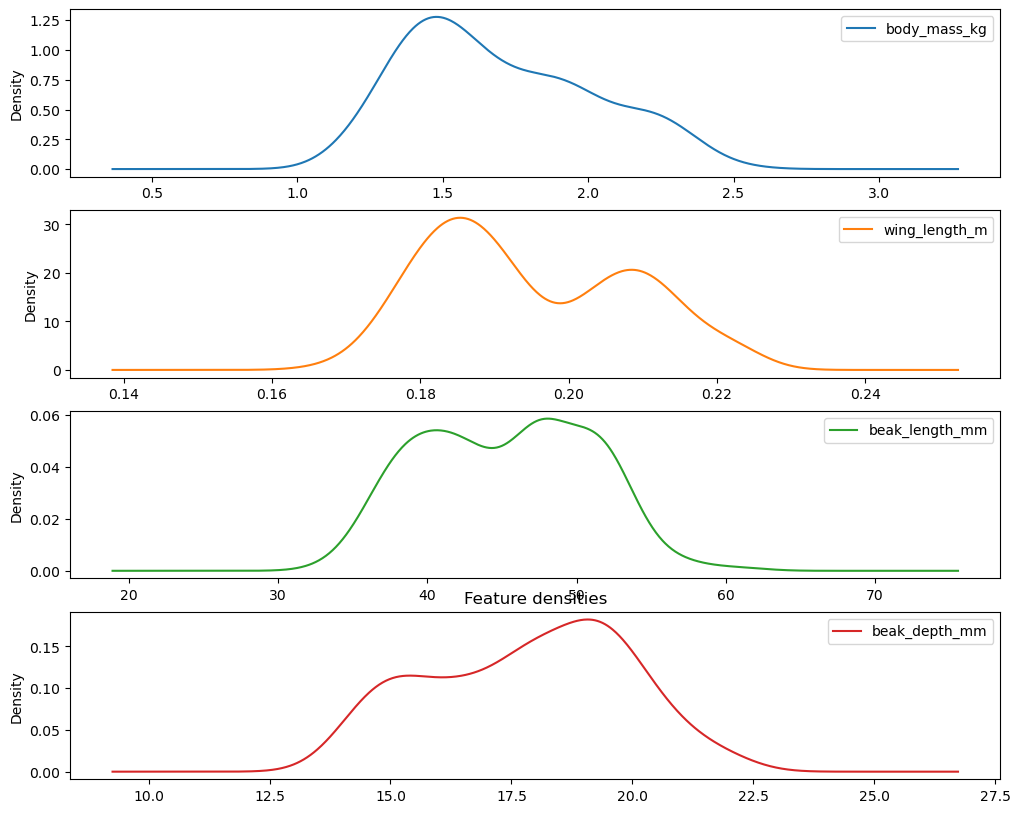

In [9]:
# visualize distribution of features for first impression
df.select_dtypes('float').plot.density(subplots=True, sharex=False)
plt.gca().figure.set_size_inches(12, 10)
plt.title("Feature densities")

Text(0.5, 1.0, 'Correlation Matrix')

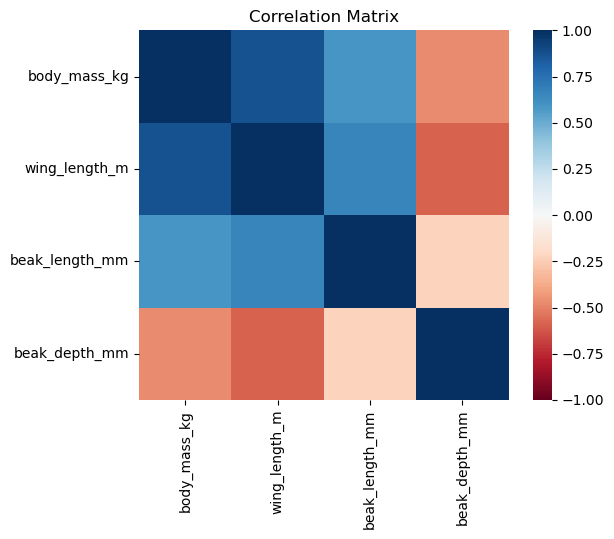

In [10]:
# Plotting the correlation
corr = df[['body_mass_kg', 'wing_length_m', 'beak_length_mm', 'beak_depth_mm']].corr()
sns.heatmap(corr, vmin=-1.0, vmax=1.0, square=True, cmap="RdBu")
plt.title("Correlation Matrix")

## 2.2 Clean data
This step will examine futher the featueres, identifying and removing those with low variance. The reason for this step is that features with minimal variation are unlikely to significantly enhance the model's predictive capability.

The potential features to remove are wing_length_m and body_mass_kg with the lowest standard deviation. 
Moreover, correlation matrix reveals that these features also share the highest correlations with other features, further suggesting their limited unique value in predictive modeling.

Here’s what will be done:  
* Using the VarianceThreshold method. This method excludes features whose variance does not meet a predefined threshold.
- Variance Threshold: A measure to filter out features that do not meet a certain threshold, assuming that features with low variance may not contribute significantly to the model's predictive power.
* Conclusion
* Clean the data from chosed feature/s.

In [11]:
# look again at the statistics of potential features to remove
df[['wing_length_m', 'body_mass_kg']].describe().round(4)

,wing_length_m,body_mass_kg
count,342.0000,341.0000
mean,0.1948,1.6954
std,0.0137,0.3220
min,0.1670,1.0910
25%,0.1840,1.4340
50%,0.1910,1.6360
75%,0.2070,1.9190
max,0.2240,2.5450


In [12]:
# import and employ VarianceThreshold

from sklearn.feature_selection import VarianceThreshold

X = df[['body_mass_kg', 'wing_length_m', 'beak_length_mm', 'beak_depth_mm']].values

# iterate over thresholds (0.0-0.4):
for i in range(0,5):
    i = i / 10.0
    # setting threshold 
    sel = VarianceThreshold(threshold=i)

    # fit the model to data
    sel.fit(X)

    # print features abive the threshold
    features_retained = df[['body_mass_kg', 'wing_length_m', 'beak_length_mm', 'beak_depth_mm']].columns[sel.get_support()]

    print(f"For threshold {i}, Features retained:", features_retained)

For threshold 0.0, Features retained: Index(['body_mass_kg', 'wing_length_m', 'beak_length_mm', 'beak_depth_mm'], dtype='object')
For threshold 0.1, Features retained: Index(['body_mass_kg', 'beak_length_mm', 'beak_depth_mm'], dtype='object')
For threshold 0.2, Features retained: Index(['beak_length_mm', 'beak_depth_mm'], dtype='object')
For threshold 0.3, Features retained: Index(['beak_length_mm', 'beak_depth_mm'], dtype='object')
For threshold 0.4, Features retained: Index(['beak_length_mm', 'beak_depth_mm'], dtype='object')


### Conclusion:   
Wing Length adds no information and can be removed.  
Body Mass adds little information, being filtered out from a low threshold of 0.2. I will further examine it and  compare model with and without it.

In [13]:
# drop wing_length_m
df = df.drop('wing_length_m', axis=1)
features = ['body_mass_kg', 'beak_length_mm', 'beak_depth_mm']

# look at data
df.select_dtypes('float').columns

Index(['body_mass_kg', 'beak_length_mm', 'beak_depth_mm'], dtype='object')

## 2.3 Visualizations per species

Text(0.5, 0.98, 'Distribution of Each Feature for Each Species')

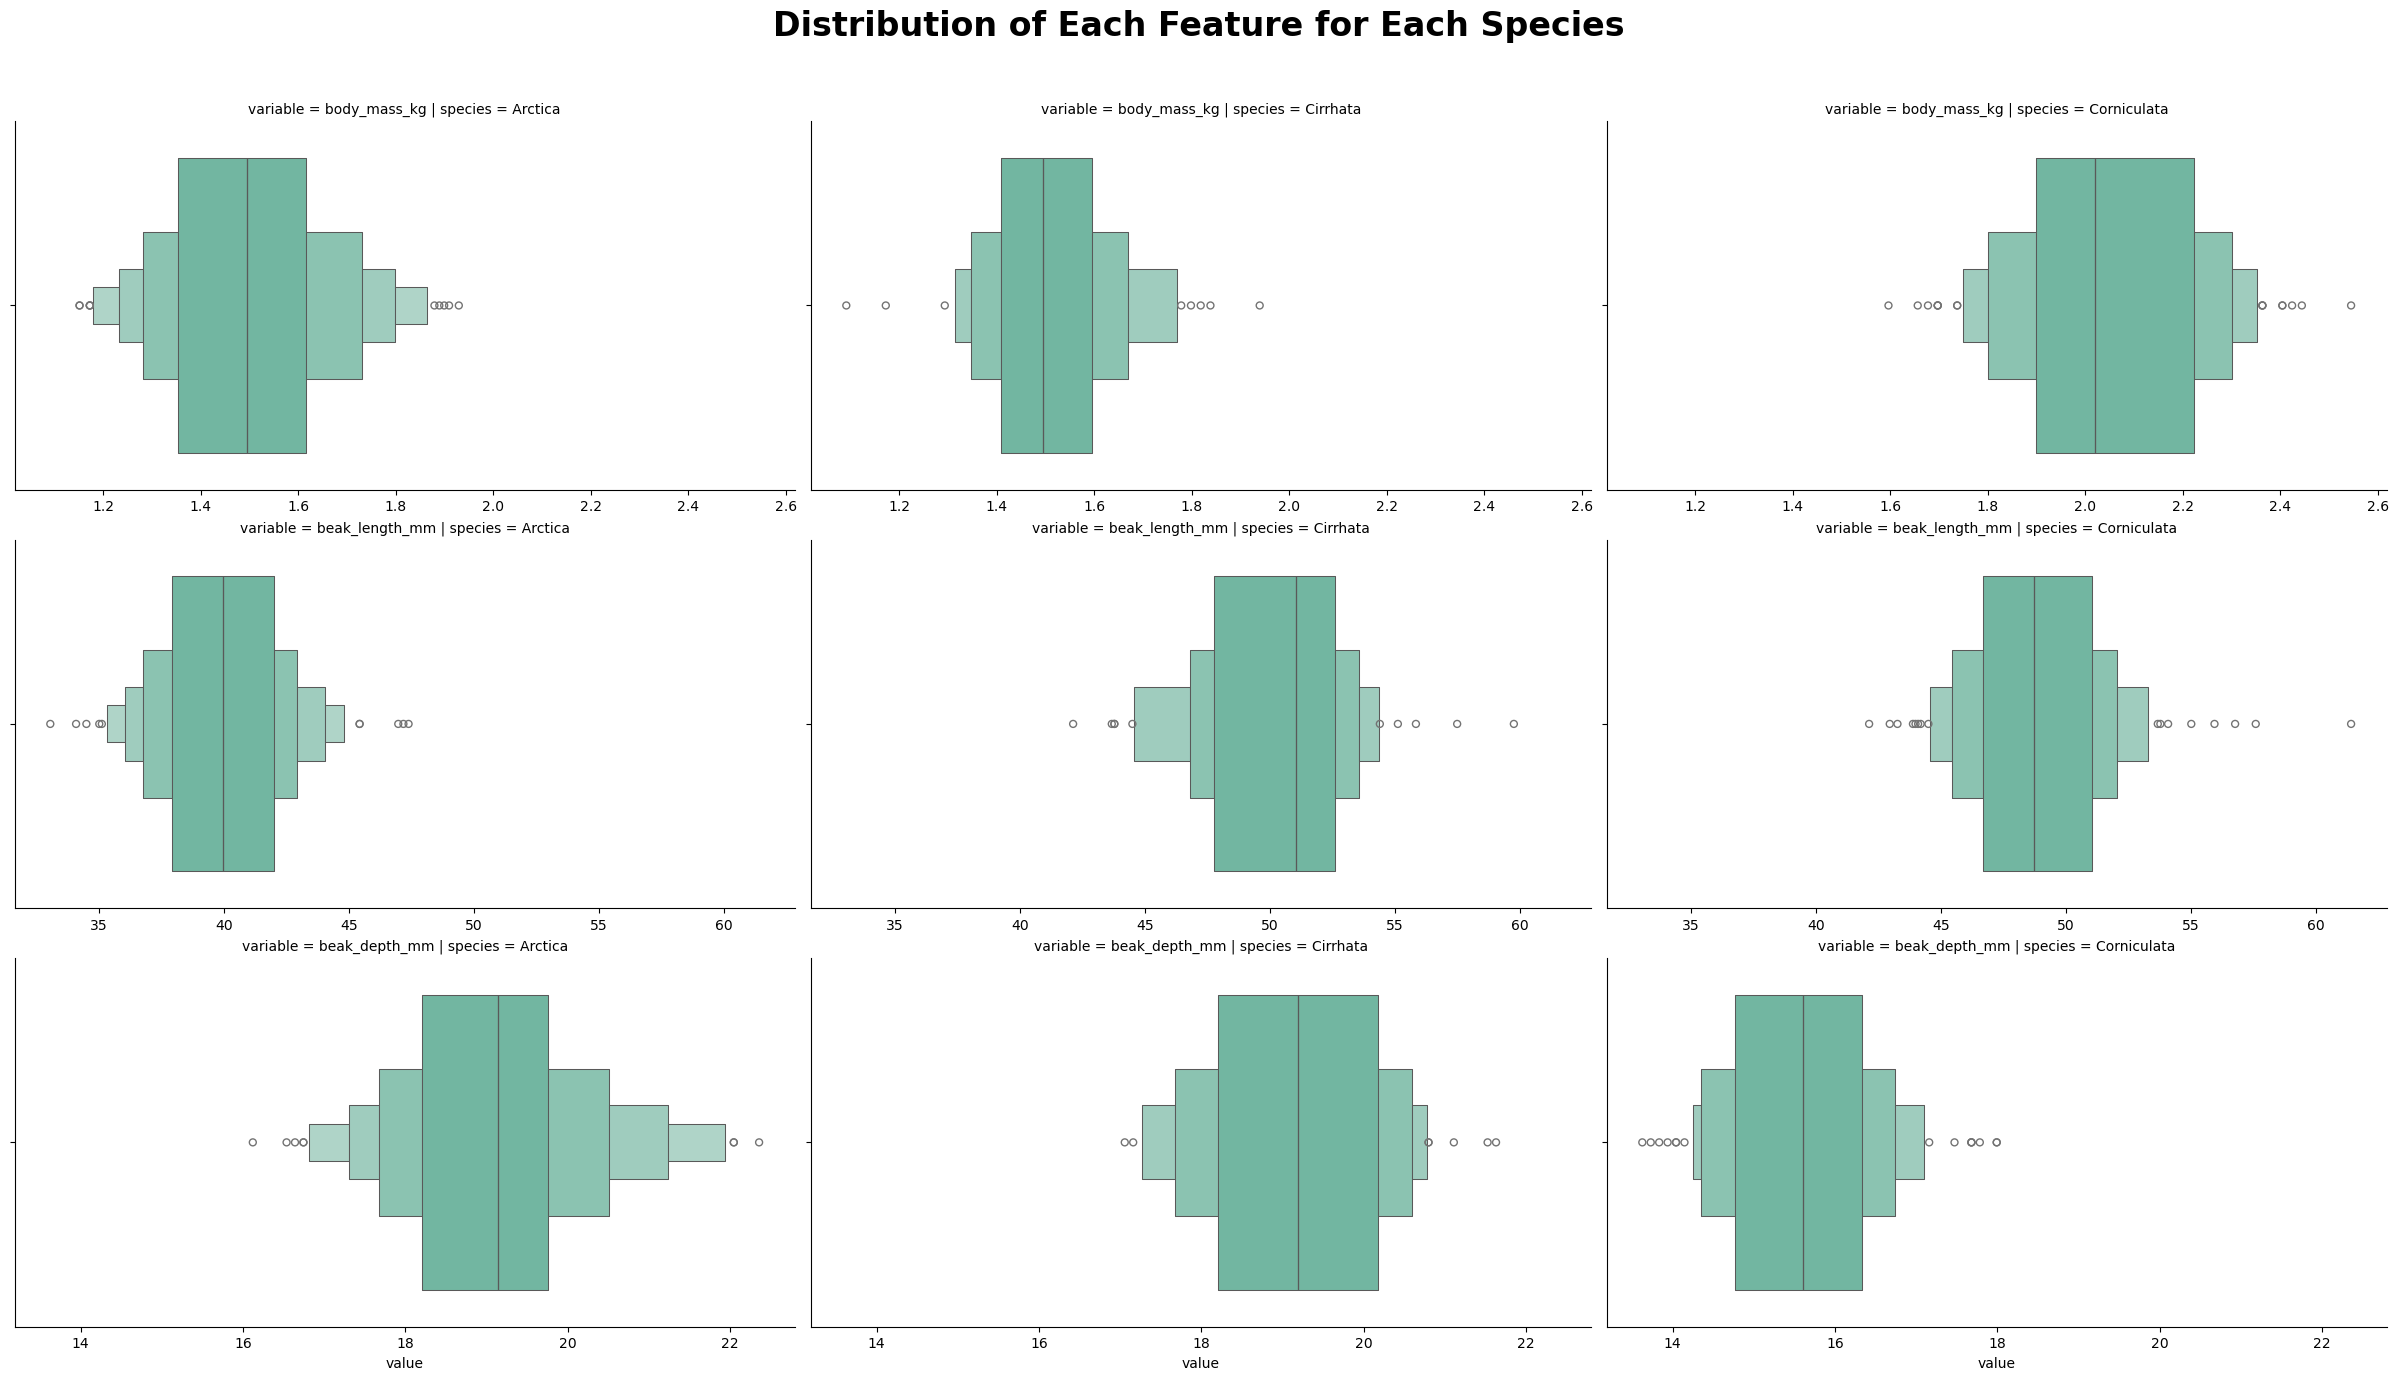

In [14]:
g = sns.catplot(kind="boxen", data=df.melt(value_vars=features, id_vars='species'),
                x='value', row='variable', col='species', sharex='row',
                palette='Set2', # Change color palette for better distinction
                height=5, aspect=2) # Change height and aspect ratio for bigger plot size

g.fig.set_size_inches(24, 14) # Make the figure larger if needed

# improve title
plt.subplots_adjust(top=0.9) # Adjust the top to make space for the title
g.fig.suptitle("Distribution of Each Feature for Each Species", fontsize=24, fontweight='bold')

### Visualize data with scatter plot 
The species classes look relatively distinct:

Text(0.5, 1.0, 'Beak dimensions per species')

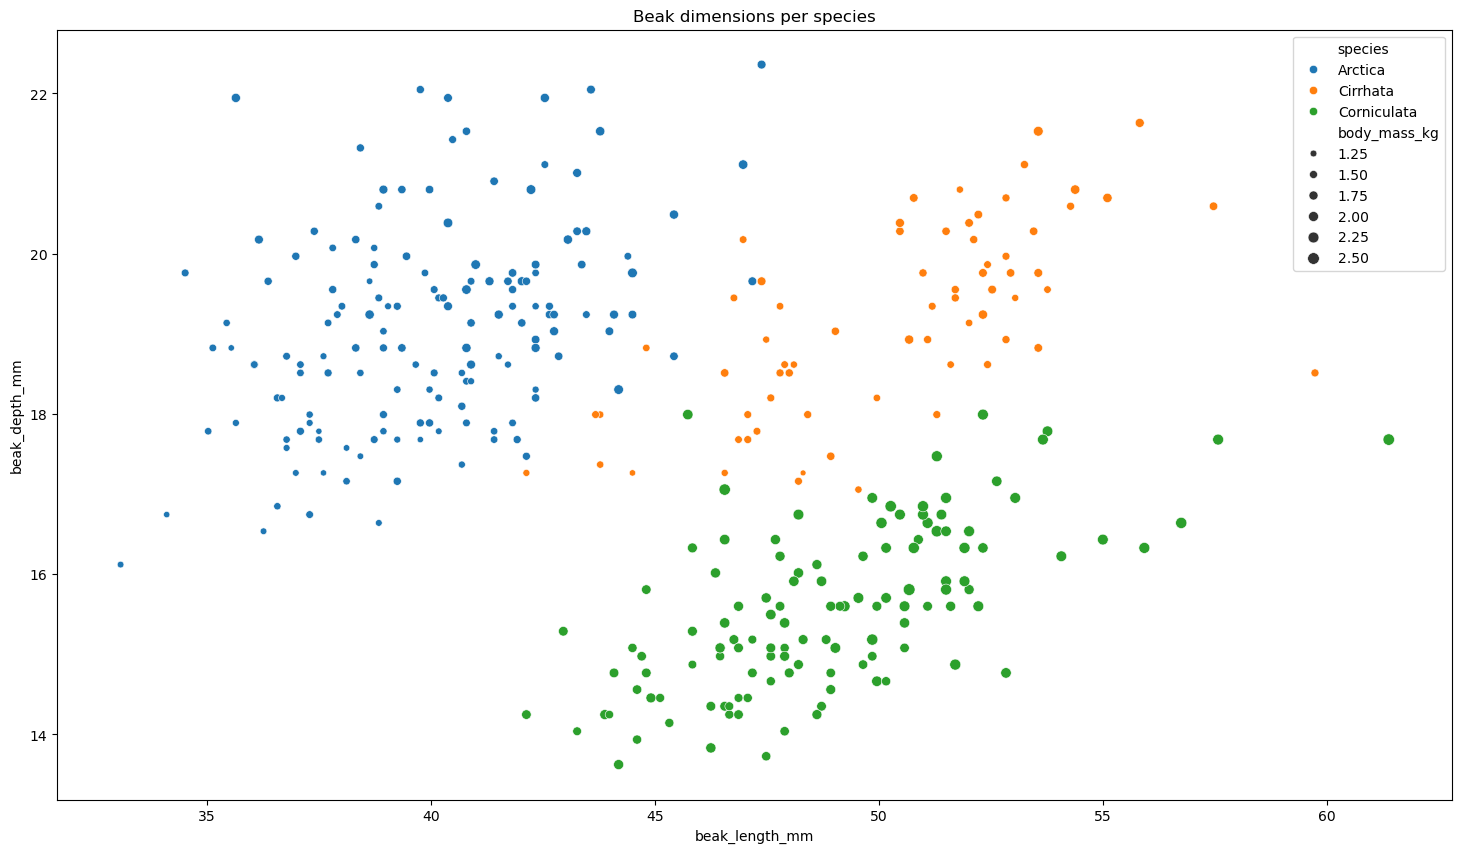

In [15]:
sns.scatterplot(data=df, x='beak_length_mm', y='beak_depth_mm', hue='species', size='body_mass_kg')
plt.gca().figure.set_size_inches(18, 10)
plt.title("Beak dimensions per species")

### A matrix of scatter plots to compare relationships between pairs of variables, colored by species.

By looking at the matrix, Corniculata's features seem to be the most distinct. Arctica and Cirrhata's features sometimes overlapp, suggesting that classifier models could confuse between the two.

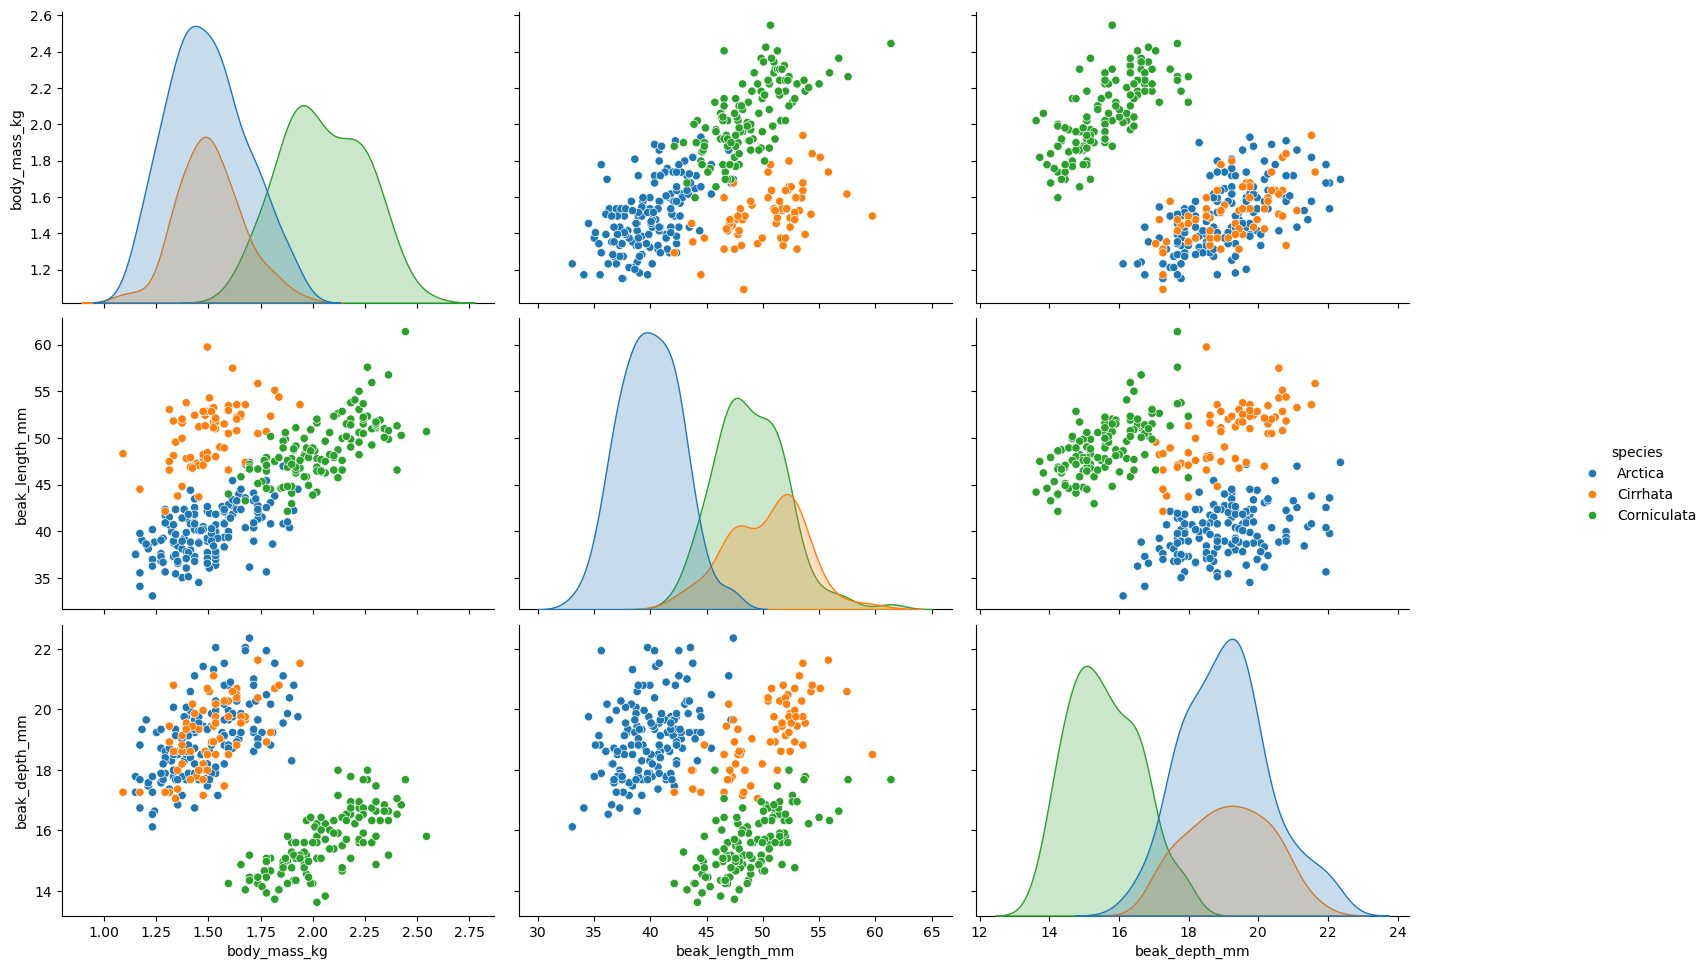

In [16]:
sns.pairplot(df, hue='species', vars=features)
plt.gca().figure.set_size_inches(18, 10)

## 2.4 Key Insights for Forward Progress
* After cleaning, the data has 3 features and 344 counts. It is simple and can be tested rapidly.
* Some counts have missing values.
* Cirrhata has less counts than other classes, which can be affect classifiers accuracy of "learning" about it.
* Body Mass feature might not be valuable for making prediction for its low variance.
* Cirrhata and Arctica classes have features with similar values, might affect models accuracy of distinguishing between them.

---
# 3. Build Classifiers

This step involves assessing three different models to determine their effectiveness.   
  
    
**Each model involves the same following steps:**
- Create pipeline: make data more suitable for the model. Last step is the model itself.
- Define hyperparameter grid setup.
- Call functions do_grid_search_and_test: The function would fit model with best hyperparameters based on a grid search and evaluate the model by making predictions, visualize prediction accuracy and misclassifications with a confusion matrix and finaly print a classification report. 
- Update comare_models data frame with accuracy of model and features importance.
- Evaluate the model's accuracy, matrix, precisions and recalls. 

Here’s what will be done:  
  
0. Build funcstion for fitting and evaluating models.
1. Fit Decision Tree model.
2. Fit Random Forest model.
3. Fit Logistic Regression model.
4. Analysis of features importance.

First, I will define my arguments for training and testing by spliting the data:

In [17]:
df

,body_mass_kg,beak_length_mm,beak_depth_mm,species
0,1.384,39.243,18.304,Arctica
1,1.717,44.084,19.240,Arctica
2,1.717,40.376,19.344,Arctica
3,1.414,37.904,19.240,Arctica
4,1.273,37.595,18.720,Arctica
...,...,...,...,...
339,1.879,44.805,15.808,Corniculata
340,1.697,46.659,14.352,Corniculata
341,2.283,55.929,16.328,Corniculata
342,2.343,50.058,16.640,Corniculata


In [18]:
# Split data into featurs, labels and each to test and train

X = df[features]
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# create data frame to compare models 
compare_models = pd.DataFrame(columns=['accuracy', 'beak_length importances', 'beak_depth importances', 'body_mass importance'])

## 3.0 Build functions

Functions description:  
* `print_feature_importances`: Prints the feature importances learned by the estimator. 
  
    
* `evaluate_predictions`:  Make predictions and evaluates the model's performance.
  
    
* `update_df_for_models_comparision`: Updates dataframe (compare_models) with model information for comparison.  
  
    
* `do_grid_search_and_test`: This function conducts a comprehensive grid search to find the optimal hyperparameters for the given pipeline, fitting the model with the best found parameters based on cross-validation scores. The best model is then automatically fit to the entire training dataset. It then evaluates the optimized model on a test dataset with evaluations like a confusion matrix and classification report. It can also prints the feature importances; which features are most influential in predictions made by the model. 




In [19]:
def print_feature_importances(estimator):
    
    """
    Returns and prints the feature importances learned by the estimator in descending order.
    
    The function is designed for an estimator that is a pipeline, where the last step is a model 
    that has a `feature_importances_` attribute (e.g., DecisionTreeClassifier).

    
    Parameters:
        - estimator: The trained model pipeline from which to extract feature importances.
        
    """
        
    print("Feature importances")

    imps = pd.Series(estimator.steps[-1][1].feature_importances_, index=X.columns)
    print(imps.sort_values(ascending=False).round(2))
    
    return imps

def evaluate_predictions(estimator):
    
    """
    Make predictions and evaluates the model's predictions by comparing them to the true labels from the test set.
    Prints out a classification report and displays a confusion matrix heatmap.
    

    Parameters:
        - estimator: The trained model to use for making predictions on X_test. This model should
                     already be fitted to the training data.

    Outputs:
        - A heatmap visualization of the confusion matrix for the test data predictions.
        - A printed classification report detailing precision, recall, f1-score, and support for each class.
    
    """
    # make predictions for the model
    y_pred = estimator.predict(X_test)

    # create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    
    print(classification_report(y_test, y_pred))
    

    
def update_df_for_models_comparison(pipeline, grid_search, imps, body_mass):
    
    """
    Updates a DataFrame with model accuracy score for best hyperparameters and the feature importances.

    Parameters:
        - pipeline: The model pipeline used for training and evaluation.
        - grid_search: The GridSearchCV object containing the model's best score and parameters.
        - description: Optional. A text description or note about the model's performance or characteristics.
        - imps: Optional. A Series containing feature importances.
        - body_mass: Checks if model includes the body mass feature.

    """
    
    # update global dataframe
    global compare_models
    
    # Model name is the class name of the last step of the pipeline
    model_name = pipeline.steps[-1][1].__class__.__name__
    
    if not body_mass:
        #if there is not body mass feature, it is the second fitting of the model
        model_name = f"{model_name}2 (no body_mass)"
        
        # check if feature importance included
        if imps is not None:
            compare_models = pd.concat([compare_models, pd.DataFrame({
            'accuracy': [grid_search.best_score_],
            'beak_length importances': [imps['beak_length_mm']], 
            'beak_depth importances': [imps['beak_depth_mm']], 
            }, index=[model_name])], axis=0)
        
        # model without features importance(regression) and no body mass feature
        else:
            compare_models = pd.concat([compare_models, pd.DataFrame({
                'accuracy': [grid_search.best_score_]
                }, index=[model_name])], axis=0)
        
    # model with body mass and features importance
    elif imps is not None:
        compare_models = pd.concat([compare_models, pd.DataFrame({
        'accuracy': [grid_search.best_score_],
        'beak_length importances': [imps['beak_length_mm']], 
        'beak_depth importances': [imps['beak_depth_mm']], 
        'body_mass importance': [imps['body_mass_kg']]
        }, index=[model_name])], axis=0)
    
    # model with body mass and without features importance(regression) 
    else:
        compare_models = pd.concat([compare_models, pd.DataFrame({
            'accuracy': [grid_search.best_score_]
            }, index=[model_name])], axis=0)
    

def do_grid_search_and_test(pipeline, param_grid, print_importances=True):
    
    """
    This function is designed to do a grid test for hyperparameters, fit the best and print evaluations of the model.
    Performs a grid search to find the best model parameters and evaluates the best model.
    Optionally prints feature importances if the model supports this feature.
    Updates dataframe with models accuracy with best hyperparameters and  feature importances.
    
    Parameters:
        - pipeline: The pipeline defining the steps of the model to train.
        - param_grid: The grid of parameters to search over for the pipeline.
        - print_importances: Boolean flag to indicate whether to print feature importances.

    Returns:
        - The estimator with the best found parameters.
    """
    
    # update global dataframe
    global compare_models
    
    # To do: check other than accuracy
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters found:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    best_estimator = grid_search.best_estimator_
    evaluate_predictions(best_estimator)
    
    body_mass = True if 'body_mass_kg' in X_test else False
    if print_importances:
        imps = print_feature_importances(best_estimator)
        
    else: 
        imps = None
    
    update_df_for_models_comparison(pipeline, grid_search, imps, body_mass)
    
    return best_estimator

## 3.1 Decision Tree model
A decision tree operates as a supervised learning approach, binary splitting data into branches to determine the class label of each instance.  

**Decision Tree Pipeline Setup (dt_pipeline)**
* SimpleImputer(): Preprocesses data by filling missing values, useful for models that can't handle NaN values directly.
* DecisionTreeClassifier(): The model.
  
**Hyperparameter Grid (dt_param_grid)**  
Defines the hyperparameter space for optimization:

* imputer__strategy: Tests both 'mean' and 'median' strategies for filling missing values.
* classifier__max_depth: Explores tree depths from 2 to 5 to balance model complexity and overfitting risk.
* classifier__max_leaf_nodes: Adjusts the maximum leaf nodes (4 to 10) to control the tree's growth and prevent overfitting.
* classifier__min_samples_leaf and classifier__min_samples_split: Sets minimum samples for leaves and splits (4, 5) to ensure large splits and prevent overly specific leaf nodes.

Decision Tree Grid Search CV: 
Best parameters found: {'classifier__max_depth': 5, 'classifier__max_leaf_nodes': 8, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4, 'imputer__strategy': 'mean'}
Best cross-validation score: 0.9588544710695499
              precision    recall  f1-score   support

     Arctica       0.95      0.88      0.91        24
    Cirrhata       0.75      0.82      0.78        11
 Corniculata       0.89      0.94      0.91        17

    accuracy                           0.88        52
   macro avg       0.86      0.88      0.87        52
weighted avg       0.89      0.88      0.89        52

Feature importances
beak_length_mm    0.59
beak_depth_mm     0.35
body_mass_kg      0.06
dtype: float64


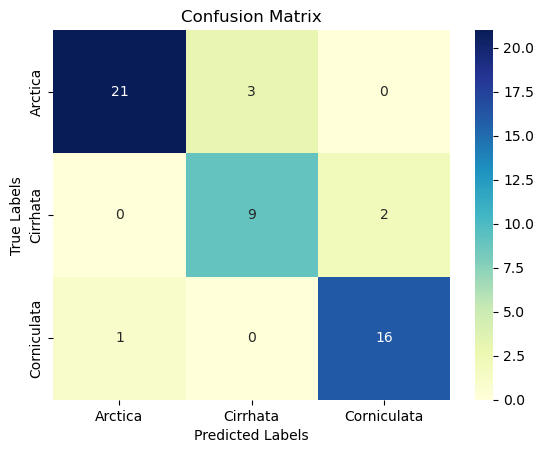

In [20]:
dt_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('classifier', DecisionTreeClassifier())
])

dt_param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'classifier__max_depth': [2, 3, 4, 5,],
    'classifier__max_leaf_nodes': [4, 6, 8, 10,],
    'classifier__min_samples_leaf': [4, 5],
    'classifier__min_samples_split': [4, 5],
}

print("Decision Tree Grid Search CV: ")
dt = do_grid_search_and_test(dt_pipeline, dt_param_grid).steps[1][1]

### Model evaluation:

* Precision: how many positive predictions of a class are true.
* Recall: how many predictions of a class were identified out of all its instances. 
---

* Good accuracy score of model, 0.9588544710695499.
* Cirrhata label has the lowest precision, hence the model only truly identify 75% of instances labeled as Cirrhata. 
* recall scores show the model is less effective of identifying Cirrhata and Arctica instances.
* Confusion matrix shows the model labeled 3 instances of Arctica as Cirrhata.

### Plot of the decision surface of the trained decision tree:

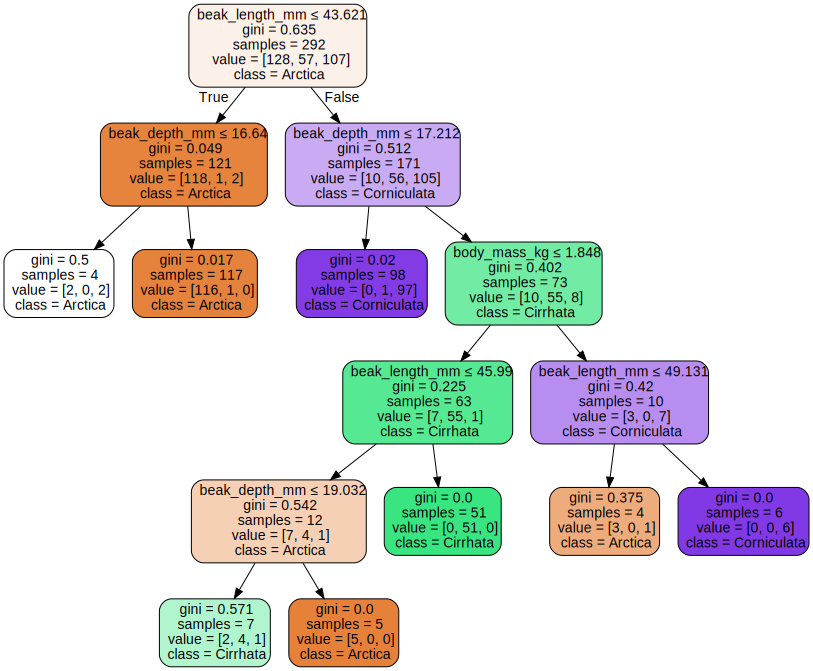

In [21]:
dot_data = export_graphviz(dt, out_file=None,
                           feature_names=X.columns,
                           class_names=np.unique(y).astype(str),
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)

graph

### Decision path:
After fitting our model and visualizing the decision tree, I employ the `print_decision_paths_with_accuracy_check` function to illustrate the tree's decision-making for chosen samples and validate prediction accuracy, providing a closer look at model performance.

In [22]:
def print_decision_paths_with_accuracy_check(dt, X_test, y_test, sample_ids):
    
    """
    Prints the decision paths used by a decision tree model for a set of samples (from test data) and checks the accuracy of each prediction.
    
    sample_ids : list of int
        Indices of the samples in `X_test` to be predicted.
        
    """
    
    for sample_id in sample_ids:
        # Predict and check against actual label
        sample_prediction = dt.predict(X_test.iloc[sample_id:sample_id+1])[0]
        actual_label = y_test.iloc[sample_id]
        prediction_correct = sample_prediction == actual_label
        
        # Fetch the decision path for the current sample
        node_indicator = dt.decision_path(X_test)
        leaf_id = dt.apply(X_test)
        
        # Iterate through the path
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:node_indicator.indptr[sample_id + 1]]
        print(f"\nRules used to predict sample {sample_id}:\n")
        
        for node_id in node_index:
            if leaf_id[sample_id] == node_id:  # Node is a leaf
                print(f"Sample {sample_id} reaches leaf node {node_id}, predicted class = {sample_prediction} (Actual class = {actual_label})")
                break
            
            # Get node details
            threshold = dt.tree_.threshold[node_id]
            feature_index = dt.tree_.feature[node_id]
            feature_name = X_test.columns[feature_index]
            threshold_sign = "<=" if X_test.iloc[sample_id, feature_index] <= threshold else ">"
            
            # Print decision rule
            print(f"decision node {node_id} : (X_test[{sample_id}, {feature_name}] = {X_test.iloc[sample_id, feature_index]}) {threshold_sign} {threshold}")

        # Print accuracy result
        print("The prediction for this sample is correct." if prediction_correct else "The prediction for this sample is incorrect.")

# Example:
sample_ids = [0,1,2,3]        
print_decision_paths_with_accuracy_check(dt, X_test, y_test, sample_ids)


Rules used to predict sample 0:

decision node 0 : (X_test[0, beak_length_mm] = 48.204) > 43.620500564575195
decision node 2 : (X_test[0, beak_depth_mm] = 17.16) <= 17.211999893188477
Sample 0 reaches leaf node 3, predicted class = Corniculata (Actual class = Cirrhata)
The prediction for this sample is incorrect.

Rules used to predict sample 1:

decision node 0 : (X_test[1, beak_length_mm] = 50.779) > 43.620500564575195
decision node 2 : (X_test[1, beak_depth_mm] = 20.696) > 17.211999893188477
decision node 4 : (X_test[1, body_mass_kg] = 1.636) <= 1.8480000495910645
decision node 5 : (X_test[1, beak_length_mm] = 50.779) > 45.98950004577637
Sample 1 reaches leaf node 8, predicted class = Cirrhata (Actual class = Cirrhata)
The prediction for this sample is correct.

Rules used to predict sample 2:

decision node 0 : (X_test[2, beak_length_mm] = 51.088) > 43.620500564575195
decision node 2 : (X_test[2, beak_depth_mm] = 16.64) <= 17.211999893188477
Sample 2 reaches leaf node 3, predicted

## 3.2 Random Forest

A random forest integrates multiple decision tree classifiers, each on a sub-sample of the dataset. The method uses averaging to improve the predictive accuracy and control over-fitting to the training data. While each individual tree is less accurate (more bias) since it uses less data, the variance is smaller (since we use many trees, which makes the overall distribution of the average score closer to the mean), which can produce better results, in terms of less chances of overfitting. Random forests are also known as effective for feature importance evaluation.
  
Uses the same Decision Tree Pipeline setup and hyperparameter grid parameters.

Random Forest Grid Search CV: 
Best parameters found: {'classifier__max_depth': 2, 'classifier__max_leaf_nodes': 4, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4, 'imputer__strategy': 'mean'}
Best cross-validation score: 0.9690824079485681
              precision    recall  f1-score   support

     Arctica       0.92      0.92      0.92        24
    Cirrhata       0.82      0.82      0.82        11
 Corniculata       0.94      0.94      0.94        17

    accuracy                           0.90        52
   macro avg       0.89      0.89      0.89        52
weighted avg       0.90      0.90      0.90        52

Feature importances
beak_length_mm    0.40
beak_depth_mm     0.30
body_mass_kg      0.29
dtype: float64


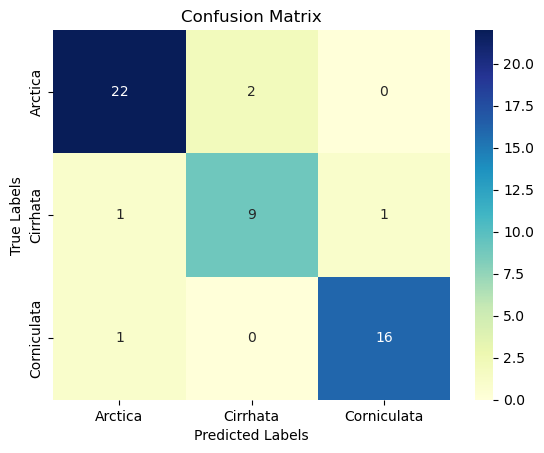

In [23]:
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('classifier', RandomForestClassifier())
])

rf_param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'classifier__max_depth': [2, 3, 4],
    'classifier__max_leaf_nodes': [4, 6, 8,],
    'classifier__min_samples_leaf': [3, 4,],
    'classifier__min_samples_split': [3, 4,],
}

print("Random Forest Grid Search CV: ")
rf = do_grid_search_and_test(rf_pipeline, rf_param_grid)

### Model evaluation:


* The model is more effective than Decision Tree model, with higher accuracy score of 0.9656341320864993.
* Overwall values of precision and recall are better. The model is better at identifying true posivtive instances of labels and classify them correctly.
* Again, confusion matrix shows the model has difficulty differentiating Arctica and Cirrhata.

Decision Tree classifier is less effective than Random Forest Classifier. Random Forest can handle variance more effectively by combining predictions from multiple trees, thereby often leading to higher accuracy in predictions across diverse datasets.


## 3.3 Logistic Regression

Logistic Regression, adjusted for multi-class cases, distinguishes between three categories by estimating probabilities. It provides probabilities for each class, offering more information than just the final prediction. 
Due to its simplicity and speed, Logistic Regression serves as an excellent baseline model. Comparing its performance to more complex algorithms can help gauge whether the added complexity of other models is justified.

**Pipeline setup** 
Includes SimpleImputer and model, with addition of StandardScaler:

- StandardScaler(): A step to handle data for logistic regression. It normalizes the features in the dataset so that they have a mean of 0 and a standard deviation of 1, resulting in a unit variance. This standartization is necessary for logistic regression, which is sensitive to the scale of the features, but not to tree-based models like decision tree or random forest.

**The grid of hyperparameters includes:**

- imputer__strategy

- classifier__penalty: Determines the type of regularization to apply.   
'l2' indicates L2 regularization, which penalizes the square of the coefficients, helping to prevent overfitting. L2 is particularly useful in scenarios where features are correlated.  
'None' means no regularization is applied, which might be suitable for data that's not subjected to overfitting.


Logistic Regression Grid Search CV: 
Best parameters found: {'classifier__penalty': 'l2', 'imputer__strategy': 'mean'}
Best cross-validation score: 0.9725306838106371
              precision    recall  f1-score   support

     Arctica       1.00      0.96      0.98        24
    Cirrhata       0.92      1.00      0.96        11
 Corniculata       1.00      1.00      1.00        17

    accuracy                           0.98        52
   macro avg       0.97      0.99      0.98        52
weighted avg       0.98      0.98      0.98        52



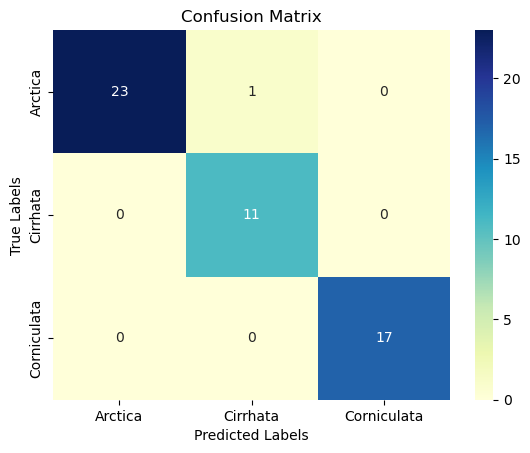

In [24]:
log_reg_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

log_reg_param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'classifier__penalty': ['l2', None]
}


print("Logistic Regression Grid Search CV: ")
log_reg = do_grid_search_and_test(log_reg_pipeline, log_reg_param_grid, print_importances=False)

### Model evaluation:

* The most effective model, with highest accuracy score of 0.9725306838106371.
* All values of precision and recall are close to 100%, with only one instance of Arctica being falsely labeled as Cirrhata.

Logistic Regression model is less complex and captures less noise in the data (overfitting), but complex enough to learn the data's patterns, being most effective at making predictions than all models tested.


### 3.4  Analysis of features importance

Here’s what will be done:  
* Compare model's features importance.
* Fit and compare models without Body Mass feature and assure its importance.

In [25]:
# print dataframe to compare models
compare_models

,accuracy,beak_length importances,beak_depth importances,body_mass importance
DecisionTreeClassifier,0.958854,0.588531,0.348718,0.062752
RandomForestClassifier,0.969082,0.402681,0.304234,0.293085
LogisticRegression,0.972531,NaN,NaN,NaN


### Compare model's features importance:
In the Decision Tree classifier, Body Mass is less important compared to other features. However, in Random Forest classifier, it gains importance, nearly matching that of other features, indicating its value in predictions.   
Logistic Regression focuses on how features linearly predict the outcome, without directly providing a measure of "importance" based on variance. 

### Fitting models without Body Mass:

In [26]:
# remove body_mass_kg
df = df.drop('body_mass_kg', axis=1)

# define features, labels, train and test for new data

features = ['beak_length_mm', 'beak_depth_mm']
X = df[features]
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Decision Tree Grid Search CV: 
Best parameters found: {'classifier__max_depth': 5, 'classifier__max_leaf_nodes': 8, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4, 'imputer__strategy': 'mean'}
Best cross-validation score: 0.9382232612507305
              precision    recall  f1-score   support

     Arctica       0.96      0.92      0.94        24
    Cirrhata       0.83      0.91      0.87        11
 Corniculata       0.94      0.94      0.94        17

    accuracy                           0.92        52
   macro avg       0.91      0.92      0.92        52
weighted avg       0.93      0.92      0.92        52

Feature importances
beak_length_mm    0.62
beak_depth_mm     0.38
dtype: float64
Random Forest Grid Search CV: 
Best parameters found: {'classifier__max_depth': 4, 'classifier__max_leaf_nodes': 8, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3, 'imputer__strategy': 'mean'}
Best cross-validation score: 0.9552893045002924
          

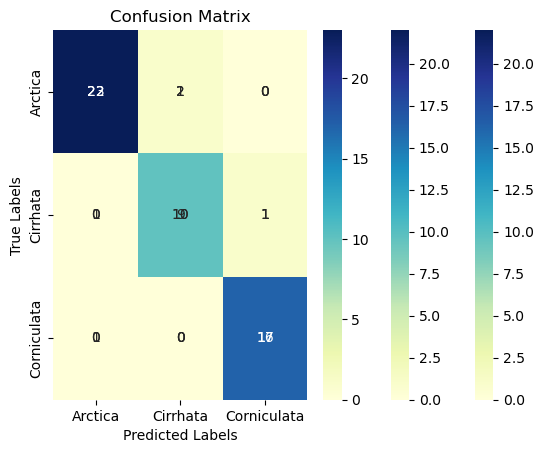

In [27]:
# fit all models 

print("Decision Tree Grid Search CV: ")
dt = do_grid_search_and_test(dt_pipeline, dt_param_grid).steps[1][1]

print("Random Forest Grid Search CV: ")
rf = do_grid_search_and_test(rf_pipeline, rf_param_grid)

print("Logistic Regression Grid Search CV: ")
log_reg = do_grid_search_and_test(log_reg_pipeline, log_reg_param_grid, print_importances=False)

In [28]:
# look at updated dataframe
compare_models

,accuracy,beak_length importances,beak_depth importances,body_mass importance
DecisionTreeClassifier,0.958854,0.588531,0.348718,0.062752
RandomForestClassifier,0.969082,0.402681,0.304234,0.293085
LogisticRegression,0.972531,NaN,NaN,NaN
DecisionTreeClassifier2 (no body_mass),0.938223,0.620265,0.379735,NaN
RandomForestClassifier2 (no body_mass),0.955289,0.539387,0.460613,NaN
LogisticRegression2 (no body_mass),0.951899,NaN,NaN,NaN


### Compare model's features importance:
Without Body Mass, all models are less accurate and less effective in all parameters. Hence, even though VarianceThreshold filtered it out at a very low threshold, it was valuable for all models performances. 

---
# 4. Data analysis pipeline effectiveness assessment

In assessing the effectiveness of the data analysis pipeline, the significance of each step will be considered.
One main strength of this analysis is its thorough documentation, showing the reason behind any change made. Specifically, when improving a model, each change was evaluated and its impact understood.


**1. Explore data, visualize and clean data:** The initial step involves identifying patterns, missing values, and outliers within the dataset. Visualization tools such as scatter plots and heat maps are important for gaining insights into the data's structure, distribution, and relationships among variables. Visualization aids in selecting the most appropriate features for the model, potentially enhancing its predictive power. Moreover, the approach forecasts model performance and identifies vulnerabilities, like the similar features between Cirrhata and Arctica.

**2. Performance evaluation:** Assessment of the model's accuracy through metrics such as accuracy scores, confusion matrices, precision and recall. This stage emphasizes the model's predictive capabilities and the nature of any errors, providing a foundation for deeper analysis and further improvement.


**3. Analyzing model:** Assessment of factors influencing model performance, including model characters, data quality, feature relevance, and model complexity. It's critical to identify issues like irrelevant features or overfitting/underfitting.


**4. Investigating improvements:** Models were continuously improved. Each model was trained using optimally selected hyperparameters via cross-validation grid search. Multiple models were tested and evaluated against each other. The choice of models was explained, based on the data characteristics and the problem being solved.

In conclusion, effective pipeline is not just about showing what is the best model, but understanding why it works and how it can be improved. This systematic and iterative approach ensures that the data analysis pipeline not only meets current needs but is also poised to adapt and evolve with future demands.

------